In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading

## Transductive Classification



#### KMeans

Loaded feature matrix with shape: (1722864, 13)
Target 'y' is now 'label' (cluster ID). Classes: [0 1 2 3 4 5 6]
Original train shape: (1378291, 12)
Balanced train shape: (161350, 12)
Classes in balanced train set: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Fitting MiniBatchKMeans on balanced training data...
Finding majority class (original cluster ID) for each new cluster...
  New Cluster 0: Majority class is 6
  New Cluster 1: Majority class is 4
  New Cluster 2: Majority class is 2
  New Cluster 3: Majority class is 4
  New Cluster 4: Majority class is 5
  New Cluster 5: Majority class is 0
  New Cluster 6: Majority class is 0

Final NewCluster-to-OriginalCluster Map: {0: np.int64(6), 1: np.int64(4), 2: np.int64(2), 3: np.int64(4), 4: np.int64(5), 5: np.int64(0), 6: np.int64(0)}

Applying to test data...

Evaluation of Clustering as Classifier (Test Set):


c:\Users\Admin\anaconda3\envs\data-mining\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\anaconda3\envs\data-mining\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Admin\anaconda3\envs\data-mining\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()}

                              precision    recall  f1-score   support

        Weekday OOS Bouncers       0.99      1.00      0.99     40517
   Weekend In-Stock Bouncers       0.00      0.00      0.00     41973
           Determined Buyers       0.46      0.99      0.63     66331
Weekday Evening OOS Bouncers       0.00      0.00      0.00     57043
Weekday Morning 'Quick-Look'       0.83      0.99      0.90      5762
        Weekend OOS Bouncers       0.77      1.00      0.87     72754
  Weekday Afternoon Bouncers       0.95      0.97      0.96     60193

                    accuracy                           0.70    344573
                   macro avg       0.57      0.71      0.62    344573
                weighted avg       0.55      0.70      0.61    344573


Accuracy (Clustering as Classifier): 0.7048056580173142

Confusion matrix plot saved as 'kmeans_classifier_multiclass_matrix.png'


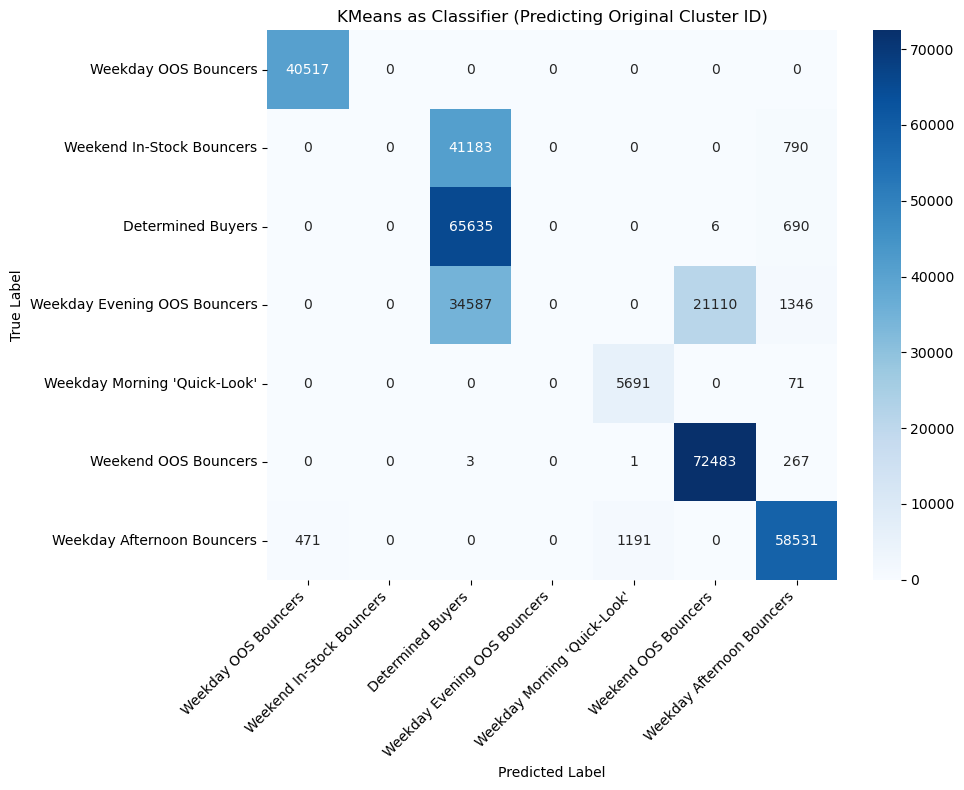

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- 1. Load Data (from Classification.ipynb cell [3]) ---
try:
    # This file has the scaled features AND the original cluster label
    df_features = pd.read_csv('session_feature_matrix_with_k7_clusters.csv', index_col='session_id')
    df_features = df_features.rename(columns={'cluster': 'label'})
    print(f"Loaded feature matrix with shape: {df_features.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_with_k7_clusters.csv' not found.")
    df_features = None # Handle error appropriately

# --- 2. Define Features (X) and MULTI-CLASS Target (y) ---
features_for_clustering = [
    'session_duration_sec', 'total_events', 'unique_items_viewed',
    'unique_categories_viewed', 'avg_item_availability',
    'session_hour_of_day', 'view_count', 'addtocart_count',
    'event_rate_per_sec', 'view_to_cart_ratio',
    'category_spread_ratio', 'is_weekend'
]

# We are using the pre-scaled data from the file
X = df_features[features_for_clustering].values

# *** THIS IS THE KEY CHANGE ***
# The target 'y' is now the multi-class 'label' (0-6)
y = df_features['label'].values
print(f"Target 'y' is now 'label' (cluster ID). Classes: {np.unique(y)}")


# --- 3. Split and Balance the Data (from cell [5] & [7]) ---
# We split and stratify based on the multi-class 'label'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Balance the *training* data (as you did before)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

print(f"Original train shape: {X_train.shape}")
print(f"Balanced train shape: {X_train_bal.shape}")
print(f"Classes in balanced train set: {sorted(list(set(y_train_bal)))}")


# --- 4. Apply Clustering Algorithm (KMeans) ---
# Reason: Fit a NEW clustering algorithm on the balanced training data
print("\nFitting MiniBatchKMeans on balanced training data...")
n_clusters = 7  # Use k=7
kmeans_eval = MiniBatchKMeans(
    n_clusters=n_clusters,
    random_state=42,
    n_init="auto",
    batch_size=2048
)
kmeans_eval.fit(X_train_bal)


# --- 5. Find Most Common Label for Each Cluster (The "Vote") ---
# Reason: "The most common labels... are defined as application
# class of the cluster."
print("Finding majority class (original cluster ID) for each new cluster...")
# Get the new cluster labels for the balanced training data
train_cluster_labels_new = kmeans_eval.predict(X_train_bal)

# This dictionary will map new_cluster_id -> original_cluster_id (0-6)
cluster_to_class_map = {}
possible_classes = sorted(list(set(y_train_bal))) # [0, 1, 2, 3, 4, 5, 6]

for k in range(n_clusters):
    # Find the indices of all points in this new cluster 'k'
    cluster_indices = np.where(train_cluster_labels_new == k)[0]
    
    if len(cluster_indices) == 0:
        # "if there are no labels, then classes are chosen randomly."
        cluster_to_class_map[k] = random.choice(possible_classes)
        print(f"  New Cluster {k}: No labels found, assigned random class {cluster_to_class_map[k]}")
    else:
        # Find the *original* 'y' labels for these points
        true_labels_for_cluster = y_train_bal[cluster_indices]
        # Find the mode (most common original label)
        scipy_mode_result = mode(true_labels_for_cluster)
        
        # We check if the .mode attribute is a scalar (single number)
        # If it's NOT a scalar, it's an array, which means there was a tie.
        if not np.isscalar(scipy_mode_result.mode):
            # "If there is a tie... classes are chosen randomly."
            cluster_to_class_map[k] = random.choice(possible_classes)
            print(f"  New Cluster {k}: Tie detected (multiple modes), assigned random class {cluster_to_class_map[k]}")
        else:
            # This is the normal case: one clear mode
            majority_class = scipy_mode_result.mode
            cluster_to_class_map[k] = majority_class
            print(f"  New Cluster {k}: Majority class is {majority_class}")

print(f"\nFinal NewCluster-to-OriginalCluster Map: {cluster_to_class_map}")


# --- 6. Apply to Test Data ---
print("\nApplying to test data...")
# 1. Predict the NEW CLUSTER for the test set
test_cluster_labels_new = kmeans_eval.predict(X_test)

# 2. Map new cluster IDs to our *predicted original cluster IDs*
y_pred = [cluster_to_class_map.get(label, 0) for label in test_cluster_labels_new]


# --- 7. Evaluate Performance ---
# Define the string names for our multi-class target
label_map = {
    0: "Weekday OOS Bouncers",
    1: "Weekend In-Stock Bouncers",
    2: "Determined Buyers",
    3: "Weekday Evening OOS Bouncers",
    4: "Weekday Morning 'Quick-Look'",
    5: "Weekend OOS Bouncers",
    6: "Weekday Afternoon Bouncers"
}
target_names = [label_map[i] for i in possible_classes]

print("\n" + "="*60)
print("Evaluation of Clustering as Classifier (Test Set):")
print("="*60)

# Compare the *true* 'y' labels (y_test)
# with the *predicted* 'y' labels (y_pred)
print(classification_report(
    y_test,
    y_pred,
    target_names=target_names
))
print("\nAccuracy (Clustering as Classifier):", accuracy_score(y_test, y_pred))


# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=possible_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('KMeans as Classifier (Predicting Original Cluster ID)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("kmeans_classifier_multiclass_matrix.png")
print("\nConfusion matrix plot saved as 'kmeans_classifier_multiclass_matrix.png'")
plt.show()

In [6]:
# Iterate over each class index (0-6)
for i in range(cm.shape[0]):
    true_positives = cm[i, i]
    total_actual_samples = np.sum(cm[i, :]) # Total true samples for this class
    
    # Calculate accuracy (recall) for the class
    if total_actual_samples > 0:
        class_accuracy = true_positives / total_actual_samples
    else:
        class_accuracy = 0.0 # Avoid division by zero
        
    class_name = label_map.get(i, f"Cluster {i}")
    print(f"{class_name + ':':<30} {class_accuracy * 100:.2f}%")

Weekday OOS Bouncers:          100.00%
Weekend In-Stock Bouncers:     0.00%
Determined Buyers:             98.95%
Weekday Evening OOS Bouncers:  0.00%
Weekday Morning 'Quick-Look':  98.77%
Weekend OOS Bouncers:          99.63%
Weekday Afternoon Bouncers:    97.24%


## GMM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import random
from imblearn.over_sampling import SMOTE

# --- 1. Load Data (from Classification.ipynb cell [3]) ---
try:
    # This file has the scaled features AND the original cluster label
    df_features = pd.read_csv('df_user_features_with_clusters.csv', index_col='session_id')
    df_features = df_features.rename(columns={'cluster_gmm': 'label'})
    print(f"Loaded feature matrix with shape: {df_features.shape}")
except FileNotFoundError:
    print("Error: 'df_user_features_with_clusters.csv' not found.")
    df_features = None # Handle error appropriately

# --- 2. Define Features (X) and MULTI-CLASS Target (y) ---
features_for_clustering = [
    'session_duration_sec', 'total_events', 'unique_items_viewed',
    'unique_categories_viewed', 'avg_item_availability',
    'session_hour_of_day', 'view_count', 'addtocart_count',
    'event_rate_per_sec', 'view_to_cart_ratio',
    'category_spread_ratio', 'is_weekend'
]

# We are using the pre-scaled data from the file
X = df_features[features_for_clustering].values

# *** THIS IS THE KEY CHANGE ***
# The target 'y' is now the multi-class 'label' (0-6)
y = df_features['label'].values
print(f"Target 'y' is now 'label' (cluster ID). Classes: {np.unique(y)}")

# --- 3. Split and Balance the Data (from cell [5] & [7]) ---
# We split and stratify based on the multi-class 'label'
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Balance the *training* data (as you did before)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_bal, y_train_bal = rus.fit_resample(X_train, y_train)

print(f"Original train shape: {X_train.shape}")
print(f"Balanced train shape: {X_train_bal.shape}")
print(f"Classes in balanced train set: {sorted(list(set(y_train_bal)))}")


# --- 4. Apply Clustering Algorithm (GMM) ---
# Reason: Fit a NEW clustering algorithm on the balanced training data
print("\nFitting GMM on balanced training data...")
n_clusters = 7  # Use k=7
gmm_k7_eval = GaussianMixture(
    n_components=7,
    # covariance_type='full',  # <--- THIS IS THE PROBLEM
    covariance_type='diag',    # <--- TRY 'diag' (less complex)
    # covariance_type='spherical', # <--- OR TRY 'spherical' (makes it behave like K-Means)
    random_state=42,
    n_init=10,
    max_iter=200
)

gmm_k7_eval.fit(X_train_bal)


# --- 5. Find Most Common Label for Each Cluster (The "Vote") ---
# Reason: "The most common labels... are defined as application
# class of the cluster."
print("Finding majority class (original cluster ID) for each new cluster...")
# Get the new cluster labels for the balanced training data
train_cluster_labels_new = gmm_k7_eval.predict(X_train_bal)

# This dictionary will map new_cluster_id -> original_cluster_id (0-6)
cluster_to_class_map = {}
possible_classes = sorted(list(set(y_train_bal))) # [0, 1, 2, 3, 4, 5, 6]

for k in range(n_clusters):
    # Find the indices of all points in this new cluster 'k'
    cluster_indices = np.where(train_cluster_labels_new == k)[0]
    
    if len(cluster_indices) == 0:
        # "if there are no labels, then classes are chosen randomly."
        cluster_to_class_map[k] = random.choice(possible_classes)
        print(f"  New Cluster {k}: No labels found, assigned random class {cluster_to_class_map[k]}")
    else:
        # Find the *original* 'y' labels for these points
        true_labels_for_cluster = y_train_bal[cluster_indices]
        # Find the mode (most common original label)
        scipy_mode_result = mode(true_labels_for_cluster)
        
        # We check if the .mode attribute is a scalar (single number)
        # If it's NOT a scalar, it's an array, which means there was a tie.
        if not np.isscalar(scipy_mode_result.mode):
            # "If there is a tie... classes are chosen randomly."
            cluster_to_class_map[k] = random.choice(possible_classes)
            print(f"  New Cluster {k}: Tie detected (multiple modes), assigned random class {cluster_to_class_map[k]}")
        else:
            # This is the normal case: one clear mode
            majority_class = scipy_mode_result.mode
            cluster_to_class_map[k] = majority_class
            print(f"  New Cluster {k}: Majority class is {majority_class}")

print(f"\nFinal NewCluster-to-OriginalCluster Map: {cluster_to_class_map}")


# --- 6. Apply to Test Data ---
print("\nApplying to test data...")
# 1. Predict the NEW CLUSTER for the test set
test_cluster_labels_new = gmm_k7_eval.predict(X_test)

# 2. Map new cluster IDs to our *predicted original cluster IDs*
y_pred = [cluster_to_class_map.get(label, 0) for label in test_cluster_labels_new]


# --- 7. Evaluate Performance ---
# *** THIS SECTION HAS BEEN UPDATED ***
# Define the string names for our multi-class target based on the
# correct GMM cluster profiles from 'GaussianMixtureModel_...ipynb'
label_map = {
    0: "Weekday OOS Bouncers",
    1: "Weekday 'Quick-Look' Visitors",
    2: "Window Shoppers",
    3: "Determined Buyers",
    4: "Weekday OOS Bouncers (No Category)",
    5: "High-Intent Shoppers",
    6: "Weekend 'Quick-Look' Visitors"
}
target_names = [label_map[i] for i in possible_classes]

print("\n" + "="*60)
print("Evaluation of Clustering as Classifier (Test Set):")
print("="*60)

# Compare the *true* 'y' labels (y_test)
# with the *predicted* 'y' labels (y_pred)
print(classification_report(
    y_test,
    y_pred,
    target_names=target_names
))
print("\nAccuracy (Clustering as Classifier):", accuracy_score(y_test, y_pred))


# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=possible_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('GMM as Classifier (Predicting Original Cluster ID)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("gmm_classifier_multiclass_matrix.png")
print("\nConfusion matrix plot saved as 'gmm_classifier_multiclass_matrix.png'")
plt.show()

Loaded feature matrix with shape: (1722864, 17)
Target 'y' is now 'label' (cluster ID). Classes: [0 1 2 3 4 5 6]
Original train shape: (1378291, 12)
Balanced train shape: (142240, 12)
Classes in balanced train set: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]

Fitting GMM on balanced training data...


In [ ]:
print("--- GMM: Accuracy (Recall) per Cluster ---")

# Iterate over each class index (0-6)
for i in range(cm.shape[0]):
    true_positives = cm[i, i]
    total_actual_samples = np.sum(cm[i, :]) # Total true samples for this class
    
    # Calculate accuracy (recall) for the class
    if total_actual_samples > 0:
        class_accuracy = true_positives / total_actual_samples
    else:
        class_accuracy = 0.0 # Avoid division by zero
        
    class_name = label_map.get(i, f"Cluster {i}")
    print(f"{class_name + ':':<30} {class_accuracy * 100:.2f}%")

--- GMM: Accuracy (Recall) per Cluster ---
Weekday OOS Bouncers:          100.00%
Weekday 'Quick-Look' Visitors: 0.00%
Window Shoppers:               93.07%
Determined Buyers:             69.08%
Weekday OOS Bouncers (No Category): 0.00%
High-Intent Shoppers:          75.20%
Weekend 'Quick-Look' Visitors: 0.00%


Characteristics of each of the 7 clusters from your `cluster_profiles.T` output.

Profile analysis for each cluster.

---

### Cluster Profile Analysis (k=7)

#### Cluster 0: Out-of-Stock Bouncers
* **Key Features (from `cluster_profiles.T` output):**
    * `is_buyer`: 0.0001 (Extremely low)
    * [cite_start]`total_events`: 1.07 (A "bounce" session [cite: 652])
    * `avg_item_availability`: **0.0** (The defining feature)
    * `unique_categories_viewed`: **0.0** (The other defining feature)
    * `is_weekend`: 0.23 (Mostly weekday)
* **Profile:** These sessions are minimal (`total_events` $\approx$ 1, `session_duration_sec` $\approx$ 16s). Their defining trait is that they land on items with **zero availability** and view **zero categories**. These are users who likely followed a link directly to an out-of-stock item and left immediately.

#### Cluster 1: Weekend 'Quick-Look' Visitors
* **Key Features (from `cluster_profiles.T` output):**
    * `is_buyer`: 0.001 (Extremely low)
    * [cite_start]`total_events`: 1.01 (A "bounce" session [cite: 652])
    * `session_duration_sec`: 0.12 (Extremely short)
    * `is_weekend`: **1.0** (The defining feature)
    * `avg_item_availability`: 0.99 (Item is in-stock)
* **Profile:** This group consists of very short, single-event "bounce" sessions that occur exclusively on the **weekend** for **in-stock** items. They are the weekend equivalent of Cluster 4.

#### Cluster 2: Determined Buyers
* **Key Features (from `cluster_profiles.T` output):**
    * `is_buyer`: **0.033** (Highest by a large margin)
    * `transaction_count`: **0.042** (Highest)
    * `addtocart_count`: **0.153** (Highest)
    * `session_duration_sec`: **442.4** (Highest, ~7.4 minutes)
    * `total_events`: **3.36** (Highest)
    * `unique_items_viewed`: **2.4** (Highest)
* **Profile:** This is your **buyer** cluster, as noted in your notebook (cell [23]). Every single metric related to engagement and purchasing (`duration`, `events`, `items_viewed`, `addtocart`, `is_buyer`) is significantly higher than in any other cluster. This group clearly represents the users with high purchase intent who complete a transaction.

#### Cluster 3: Weekday Evening Bouncers
* **Key Features (from `cluster_profiles.T` output):**
    * `is_buyer`: 0.0003 (Extremely low)
    * [cite_start]`total_events`: 1.01 (A "bounce" session [cite: 652])
    * `session_duration_sec`: 0.30 (Extremely short)
    * `is_weekend`: **0.0** (The defining feature)
    * `session_hour_of_day`: **20.9** (Late evening)
    * `avg_item_availability`: 0.0001 (Item is out-of-stock)
* **Profile:** This is another "bounce" session cluster, but with a specific time profile. They are **weekday** sessions occurring in the **late evening** (around 9 PM) that land on **out-of-stock** items and immediately leave.

#### Cluster 4: Weekday Morning 'Quick-Look' Visitors
* **Key Features (from `cluster_profiles.T` output):**
    * `is_buyer`: 0.0009 (Extremely low)
    * [cite_start]`total_events`: 1.01 (A "bounce" session [cite: 652])
    * `session_duration_sec`: 0.29 (Extremely short)
    * `is_weekend`: **0.0** (The defining feature)
    * `session_hour_of_day`: **9.4** (Morning)
    * `avg_item_availability`: 0.63 (Item is in-stock)
* **Profile:** This is the largest cluster (33.3% of all sessions). Their behavior is minimal ("bounce" sessions), but their clear signature is browsing on a **weekday morning** (around 9:25 AM) for **in-stock** items. This could represent users quickly checking an item during their commute or at the start of the workday.

#### Cluster 5: Weekend Out-of-Stock Bouncers
* **Key Features (from `cluster_profiles.T` output):**
    * `is_buyer`: 0.0002 (Extremely low)
    * [cite_start]`total_events`: 1.03 (A "bounce" session [cite: 652])
    * `is_weekend`: **1.0** (The defining feature)
    * `avg_item_availability`: **0.000009** (The other defining feature)
* **Profile:** This cluster is the weekend equivalent of Clusters 0, 3, and 6. They are minimal-engagement "bounce" sessions that occur exclusively on the **weekend** and land on **out-of-stock** items.

#### Cluster 6: Weekday Afternoon Bouncers
* **Key Features (from `cluster_profiles.T` output):**
    * `is_buyer`: 0.0001 (Extremely low)
    * [cite_start]`total_events`: 1.01 (A "bounce" session [cite: 652])
    * `session_duration_sec`: 0.09 (The lowest duration)
    * `is_weekend`: **0.0** (The defining feature)
    * `session_hour_of_day`: **15.9** (Afternoon)
    * `avg_item_availability`: 0.00004 (Item is out-of-stock)
* **Profile:** This cluster is nearly identical to Cluster 3 (Weekday, OOS) but differs by time of day. These are the absolute fastest "bouncers" (0.09s duration), occurring on **weekday afternoons** (around 4 PM) and landing on **out-of-stock** items.

### Some notes for the Association Rule Mining:

Market Basket Filtering
Reason (Why): Our project requires us to find the unique patterns within our "Determined Buyer" cluster (Cluster 4), not the patterns of all buyers. We must first isolate the transactions from this specific cluster.

How (Implementation):

Load the session_feature_matrix_with_clusters.csv file you just created.

Identify all session_ids that belong to Cluster 4.

Load df_events (from COS781_Data_Cleaning_+_Features.ipynb, Cell 11) and find all transactionids associated with those Cluster 4 session_ids.

Load our full market basket files (item_baskets.csv and category_baskets.csv).

Filter these files to create two new lists: cluster_4_item_baskets and cluster_4_category_baskets, containing only the transactions from our target cluster.

Result (What we have): A clean, filtered list of market baskets (both item-level and category-level) that represent only the purchasing behavior of the "Determined Buyer" segment.

###  (Recommended) Category-Level Market Basket Analysis
Reason (Why): The user requested this. Mining by itemid can be too specific (sparse). Mining by categoryid provides more general and interpretable rules (e.g., "users who buy Electronics also buy Batteries").

How (Implementation): We will use the cluster_4_category_baskets list (created in the step above) as the primary input for the Apriori algorithm.

Result (What we have): High-level, interpretable rules based on product categories.

### Section Title: Association Rule Mining (Apriori)
Reason (Why): To discover the high-strength, statistically significant purchasing patterns that define our "Determined Buyer" cluster.

How (Implementation):

Use mlxtend.preprocessing.TransactionEncoder to one-hot encode our cluster_4_category_baskets list.

Use mlxtend.frequent_patterns.apriori on the one-hot encoded DataFrame to find frequent itemsets (categories).

Use mlxtend.frequent_patterns.association_rules to generate the final rules.

Sort the resulting rules by Lift (our key success metric) in descending order.


Result (What we have): A DataFrame of "Cluster-Specific Rules" (e.g., {Category A} -> {Category B}) ranked by Support, Confidence, and Lift.

### Section Title: Baseline Model Generation

Reason (Why): Our project's success is measured by comparing our cluster-specific rules against a baseline. We need to prove our 2-stage methodology provides better (higher-Lift) rules than a simple, one-stage analysis.


How (Implementation): Repeat Step 3 (Apriori), but this time use the full, unfiltered category_baskets.csv file (all 17,672 baskets).

Result (What we have): A "Baseline Rules" DataFrame, also with Support, Confidence, and Lift.